In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models

import datetime

In [2]:
import random
import numpy as np
import os

DEFAULT_RANDOM_SEED = 42

def set_all_seeds(seed=DEFAULT_RANDOM_SEED):

    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(seed=DEFAULT_RANDOM_SEED)

In [3]:
# hyperparameter setting
learning_rate = 0.0001
num_epochs = 20
batch_size = 128

# device detection (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
class ImageDataset(Dataset):
    '''
    Dataset class for loading and processing images and labels from NumPy arrays.
    '''

    def __init__(self, images, labels, transforms):
        '''
        Initialization of the dataset.

        Args:
            Images (numpy.ndarray): Numpy array with images.
            labels (numpy.ndarray): NumPy array with labels.
            transforms (torchvision.transforms, optional): Transforms to apply to images.
        '''
        
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        '''
        Returns the length of the dataset (number of images).
        '''
        
        return len(self.images)

    def __getitem__(self, index):
        '''
        Returns a single element from the dataset (image and label) at the given index.

        Args:
            index (int): The index of an element in the dataset.

        Returns:
            tuple: A tuple containing the transformed image and label.
        '''
        
        image = self.images[index]
        label = self.labels[index]

        # Apply transformations (if defined)
        if self.transforms is not None:
            image = self.transforms(image)

        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).float()

        if isinstance(label, np.ndarray):
            label = torch.from_numpy(label).long()

        return image, label


In [5]:
# load images and labels from .npy format to Numpy arrays
images = np.load('./images.npy')
labels = np.load('./labels.npy')

# define transforms
data_transforms = transforms.Compose([
    transforms.ToTensor(), # to torch tensor
    transforms.Grayscale() # to one channel
])

# defining and customizing the dataset
dataset = ImageDataset(images, labels, transforms=data_transforms)

# dividing the data set into training and test samples
train_data, test_data = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), int(0.2 * len(dataset))])

# defining and customizing the train and test dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
# load CNN model ResNet18
model = models.resnet18(pretrained=False)

# setting number of classes
num_classes = 3

# setting the first convolution layer
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# number of input functions for the last layer
num_features = model.fc.in_features

# new fully connected layer
model.fc = nn.Linear(num_features, num_classes)

model.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# log setting
current_time = datetime.datetime.now()
log_file = f'./model_checkpoint/training_log{current_time.strftime("%Y-%m-%d_%H-%M-%S")}.txt'
model_save_path = f'./model_checkpoint/model_{current_time.strftime("%Y-%m-%d_%H-%M-%S")}.pt'

In [9]:
def train_and_validate(epoch, model):
    
    # training
    print(f"epoch {epoch + 1}/{num_epochs}")
    
    # set model to training mode
    model.train()
    
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()
        
        # gradient cleaning
        optimizer.zero_grad()
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
    
        # backward
        loss.backward()
        optimizer.step()
    
    train_loss.append(loss.cpu())
    
    # validation
    model.eval()
    
    test_loss = 0.0
    accuracy = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.long()
    
            outputs = model(images)
    
            # calculation loss and accuracy on test data
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    accuracy /= total
    
    train_acc.append(accuracy)
    
    # Recording data on training results to a log file
    with open(log_file, 'a') as f:
        f.write(f'test_loss: {test_loss:.4f} | test_accuracy: {accuracy:.4f}')
        f.write('\n')
    
    print(f'test_loss: {test_loss:.4f} | test_accuracy: {accuracy:.4f}')

    return test_loss, model

In [10]:
# Хранение истории потерь и точности
train_loss = []
train_acc = []

In [11]:
best_loss = float('inf')
epochs_without_improvement = 0
early_stopping_threshold = 5

# training loop
for epoch in range(num_epochs):
    test_loss, model = train_and_validate(epoch, model)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_weights = model.state_dict()
        print(f'Best weights on {epoch + 1} EPOCH')
        print()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        
    if epochs_without_improvement >= early_stopping_threshold:
        print("Early stopping triggered after {} epochs without improvement.".format(epochs_without_improvement))
        break


epoch 1/20
test_loss: 4.1820 | test_accuracy: 0.3987
Best weights on 1 EPOCH

epoch 2/20
test_loss: 0.7556 | test_accuracy: 0.7320
Best weights on 2 EPOCH

epoch 3/20
test_loss: 0.7353 | test_accuracy: 0.7487
Best weights on 3 EPOCH

epoch 4/20
test_loss: 0.7266 | test_accuracy: 0.7831
Best weights on 4 EPOCH

epoch 5/20
test_loss: 1.3125 | test_accuracy: 0.7380
epoch 6/20
test_loss: 0.7235 | test_accuracy: 0.8354
Best weights on 6 EPOCH

epoch 7/20
test_loss: 0.7285 | test_accuracy: 0.8164
epoch 8/20
test_loss: 0.9301 | test_accuracy: 0.7796
epoch 9/20
test_loss: 0.8698 | test_accuracy: 0.7897
epoch 10/20
test_loss: 1.2411 | test_accuracy: 0.7190
epoch 11/20
test_loss: 0.8426 | test_accuracy: 0.8105
Early stopping triggered after 5 epochs without improvement.


In [12]:
# Saving the model state
torch.save(model.state_dict(best_weights), model_save_path)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/module.py:1877: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [13]:
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

In [14]:
# Create a catalog to save the graphs
if not os.path.exists('training_graphs'):
    os.makedirs('training_graphs')

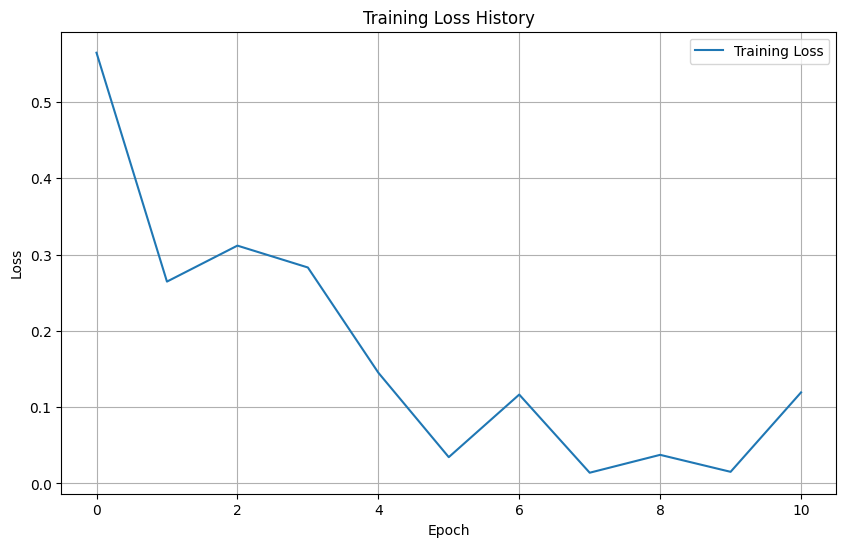

In [15]:
# the loss graph
plt.figure(figsize=(10, 6))

train_loss_tensor = torch.tensor(train_loss) 
train_loss_detached = train_loss_tensor.detach()

plt.plot(train_loss_detached.numpy(), label='Training Loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)

# Saving the loss graph
plt.savefig(os.path.join('training_graphs', 'training_loss.png'))
plt.show()
plt.close()

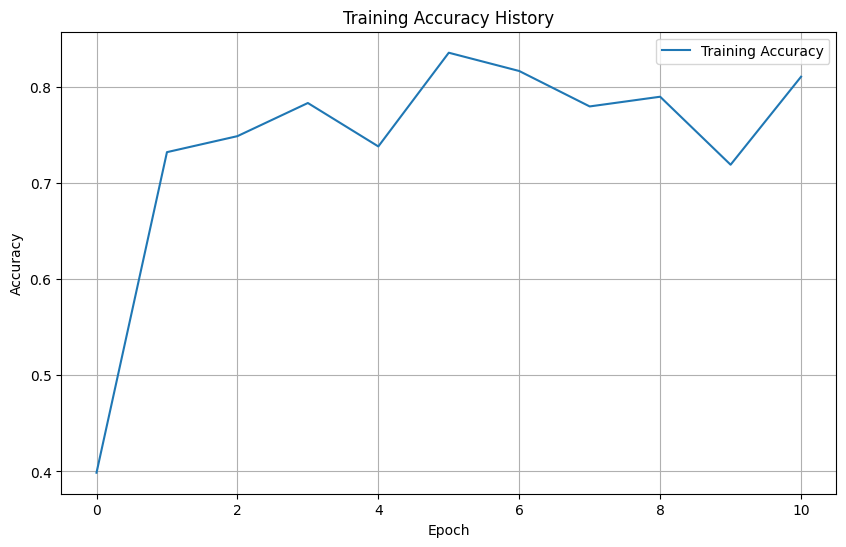

In [16]:
# the accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy History')
plt.legend()
plt.grid(True)

# Saving the accuracy graph
plt.savefig(os.path.join('training_graphs', 'training_accuracy.png'))
plt.show()
plt.close()